In [4]:
# Import libraries
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import re

# Read data
data = pd.read_csv('merged_conversations.csv',encoding='utf-8-sig')
data

,SourceType,SourceURL,SourceAuthor,SourceTitle,Prompt,Answer,ListOfCode,ChatgptURL,DateOfConversation,Model,NumberOfPrompts,TokensOfPrompts,TokensOfAnswers
0,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,"Hey, I am working on writing a technical docum...","Of course, I'd be happy to help you translate ...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
1,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,I noticed that I've already have translated co...,"Absolutely, I'd be glad to help you refine the...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
2,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,# Working Principle of dae\n\n[**简体中文**](../zh...,Working Principle of dae简体中文 | Englishdae oper...,[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
3,pull request,https://github.com/daeuniverse/dae-wing/pull/115,dae-bot,chore(sync): keep upstream source up-to-date,Is the gramma refined?,"Yes, the grammar has been refined in the provi...",[],https://chat.openai.com/share/9fb7d601-2a86-40...,"August 25, 2023",Default,4,1653,1533
4,pull request,https://github.com/FlorianWoelki/obsidian-symb...,sharshuv-quotient,Fix constructor being converted to undefined,I have this code:\n\nconst characterMap: Chara...,This issue arises because object property look...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '...",https://chat.openai.com/share/acece149-6d4b-45...,"August 23, 2023",Default,2,223,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18753,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Let's work this out in a step-by-step way to b...,"Sure, we can use a similar approach to the one...",[],https://chat.openai.com/share/62a8cdf2-6de6-49...,"May 27, 2023",Default,2,91,528
18754,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Who is Obie Fernandez and what is he famous for?,Obie Fernandez is a well-known figure in the f...,[],https://chat.openai.com/share/e42ed290-4b31-4d...,"May 27, 2023",Default,2,24,318
18755,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,Sure go ahead. I'm interested in his other pur...,Obie Fernandez is a Ruby and Ruby on Rails dev...,[],https://chat.openai.com/share/e42ed290-4b31-4d...,"May 27, 2023",Default,2,24,318
18756,hacker news,https://news.ycombinator.com/item?id=36091388,obiefernandez,ChatGPT conversations can be shared publicly,"What is Hacker News, what can you tell me abou...",Hacker News is a social news website focusing ...,[],https://chat.openai.com/share/66169853-d00a-4b...,"May 27, 2023",Default,1,17,390


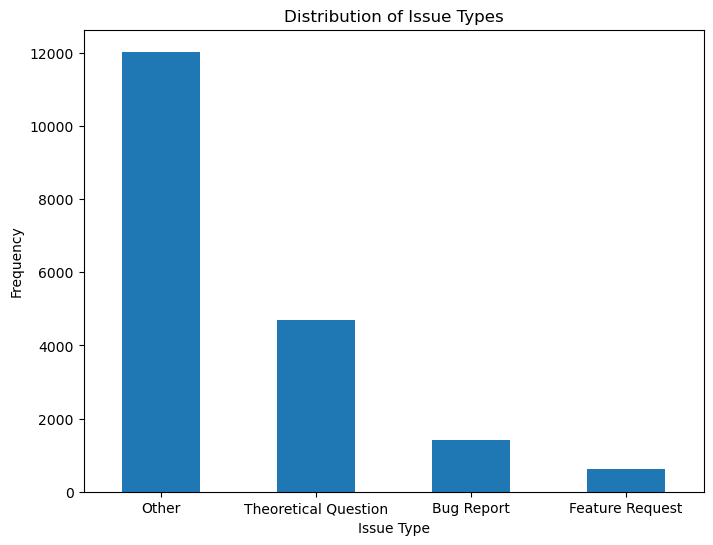

In [3]:
# Question 1: Classify Issues

data['Prompt'] = data['Prompt'].fillna('').astype(str)

# Define classify_issue function
def classify_issue(prompt):
    prompt = prompt.lower()
    if 'bug' in prompt or 'error' in prompt:
        return 'Bug Report'
    elif 'feature' in prompt or 'enhance' in prompt:
        return 'Feature Request'
    elif 'how to' in prompt or '?' in prompt:
        return 'Theoretical Question'
    else:
        return 'Other'


data['IssueType'] = data['Prompt'].apply(classify_issue)

# Classify Issue and Plot
issue_counts = data['IssueType'].value_counts()
plt.figure(figsize=(8, 6))
issue_counts.plot(kind='bar')
plt.title('Distribution of Issue Types')
plt.xlabel('Issue Type')
plt.ylabel('Frequency')
_ = plt.xticks(rotation=0)
plt.show()


Most common patterns in prompts:
[('string', 21073), ('you', 12630), ('name', 11768), ('with', 11537), ('1', 8735), ('0', 8639), ('from', 8058), ('s', 7300), ('if', 6811), ('as', 6492), ('are', 5767), ('by', 5737), ('can', 5435), ('item', 5429), ('your', 5402), ('not', 5270), ('be', 5245), ('passage', 5036), ('we', 4819), ('2', 4812)]


<Figure size 1000x600 with 0 Axes>

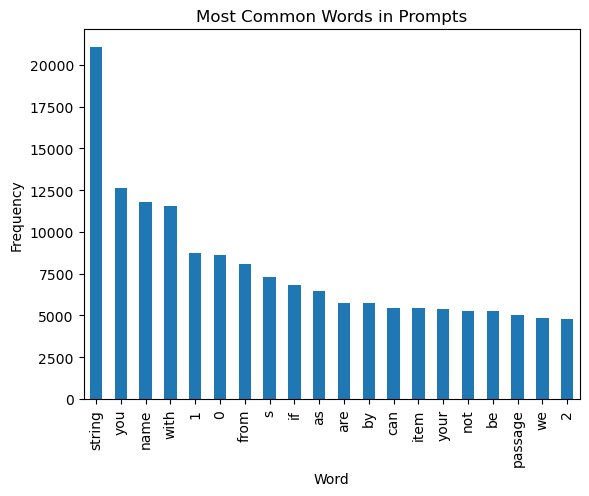

Patterns most correlated with resolution:
Resolved    1.000000
new         0.013154
if          0.011805
text        0.010419
have        0.010229
we          0.009718
are         0.009623
data        0.009122
what        0.008757
user        0.008512
Name: Resolved, dtype: float64


<Figure size 1000x600 with 0 Axes>

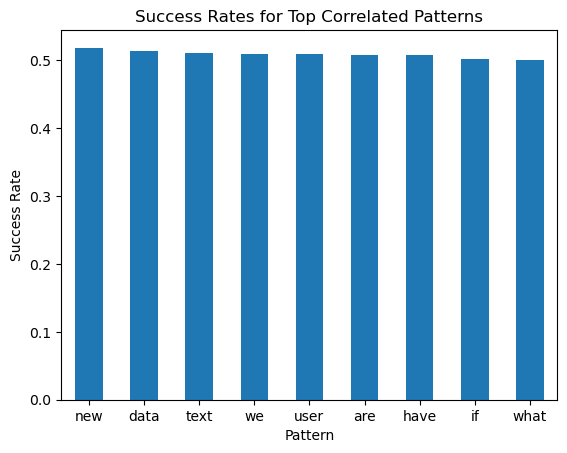

In [13]:
# Question 2: Classify Most Common Patterns in Prompts

# Define preprocess_prompt funtion
def preprocess_prompt(prompt):
  
    tokens = re.findall(r'\b\w+\b', str(prompt).lower())  

    stop_words = set(["i", "am", "is", "the", "and", "or", "on", "a", "an", "of", "to", "in", "for", "this", "that", "it"])
    return [word for word in tokens if word not in stop_words]


data['ProcessedPrompt'] = data['Prompt'].fillna('').apply(preprocess_prompt)

all_words = [word for words in data['ProcessedPrompt'] for word in words]
word_counts = Counter(all_words)

print("Most common patterns in prompts:")
print(word_counts.most_common(20))

# Plot Results
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 6))
common_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False)
plt.title('Most Common Words in Prompts')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

data['ProcessedPromptString'] = data['ProcessedPrompt'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer(max_features=50)  
X = vectorizer.fit_transform(data['ProcessedPromptString'])
feature_names = vectorizer.get_feature_names_out()

word_frequencies = pd.DataFrame(X.toarray(), columns=feature_names)

if 'Resolved' in data.columns:
    word_frequencies['Resolved'] = data['Resolved']
else:
    
    word_frequencies['Resolved'] = [1 if i % 2 == 0 else 0 for i in range(len(word_frequencies))]


correlations = word_frequencies.corr()['Resolved'].sort_values(ascending=False)
print("Patterns most correlated with resolution:")
print(correlations.head(10))


top_patterns = correlations.head(10).index


success_rates = {}
for pattern in top_patterns:
    if pattern != 'Resolved': 
        success_rates[pattern] = word_frequencies[word_frequencies[pattern] > 0]['Resolved'].mean()


success_rates_df = pd.DataFrame.from_dict(success_rates, orient='index', columns=['Success Rate'])

# Plot Results
plt.figure(figsize=(10, 6))
success_rates_df.sort_values(by='Success Rate', ascending=False).plot(kind='bar', legend=False)
plt.title('Success Rates for Top Correlated Patterns')
plt.xlabel('Pattern')
plt.ylabel('Success Rate')
_ = plt.xticks(rotation=0)
plt.show()


In [14]:
# Question 3:

#data['ListOfCode'].value_counts()
import ast
def extract_types(list_of_code):
    if pd.isna(list_of_code) or list_of_code == '[]':
        return []
    return[item.get('Type') for item in ast.literal_eval(list_of_code) if 'Type' in item]

data['ExtractedTypes'] = data["ListOfCode"].apply(extract_types)
data['ExtractedTypes'].value_counts()

ExtractedTypes
[]                          11517
[python]                      795
[javascript]                  609
[sh]                          608
[bash]                        282
                            ...  
[yaml, bash, yaml, bash]        1
[yaml, txt, yaml]               1
[css, yaml, txt, yaml]          1
[sh, sql, swift]                1
[go, swift]                     1
Name: count, Length: 802, dtype: int64

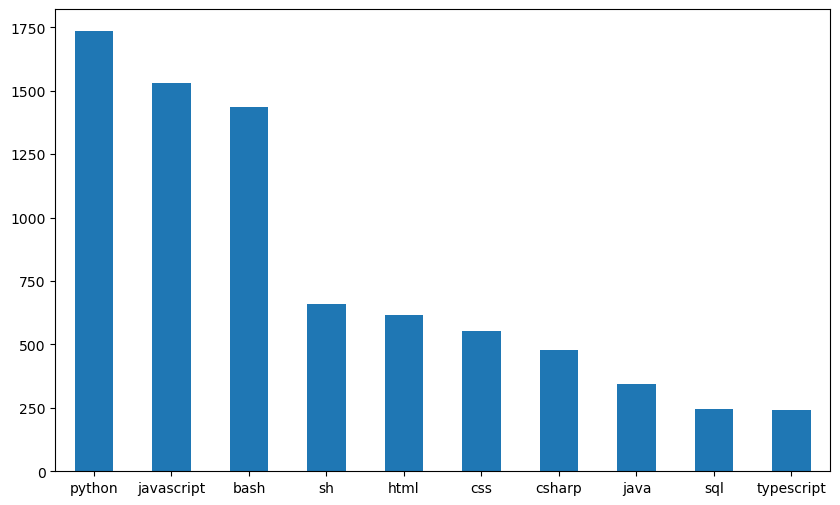

In [15]:
from collections import Counter
from itertools import chain
type_counts = Counter(chain.from_iterable(data["ExtractedTypes"]))
type_counts_series = pd.Series(type_counts)
type_counts_series.sort_values(ascending=False)[:10].plot(kind='bar', figsize=(10,6))
_ = plt.xticks(rotation=0)

In [33]:
# Function to extract types
def extract_types(list_of_code):
    if pd.isna(list_of_code) or list_of_code == '[]':
        return []
    return [item.get('Type') for item in ast.literal_eval(list_of_code) if 'Type' in item]

# Extract types and filter for Python snippets
data['ExtractedTypes'] = data["ListOfCode"].apply(extract_types)
data['ExtractedContent'] = data["ListOfCode"].apply(lambda x: [
    item.get('Content') for item in ast.literal_eval(x) 
    if 'Type' in item and item['Type'] == 'sql'
])

# Flatten and find unique Python snippets
all_sql_contents = list(chain.from_iterable(data['ExtractedContent']))
unique_sql_contents = list(set(all_sql_contents))

In [49]:
import sqlite3

def simulate_sql_execution(sql_code):
    try:
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        cursor = conn.cursor()
        # Execute SQL code (ensure it's safe to run, e.g., no injections)
        cursor.execute(sql_code)
        conn.commit()  # Commit if it's a DML statement
        conn.close()
        return None  # No error
    except sqlite3.OperationalError as e:
        # Check if the error message contains 'no such table'
        if "no such table" in str(e).lower():
            return "table does not exist"
        elif "syntax" in str(e).lower():
            return "Syntax error" 
        elif "unrecognized token":
            return "unrecognized token"
        else:
            return str(e)
    except Exception as e:
        return str(e)  # Return any other general errors


In [51]:
# Map each SQL code to its error (if any)
error_mapping = {}
for sql_code in unique_sql_contents:
    error_message = simulate_sql_execution(sql_code)
    if error_message:
        error_mapping[sql_code] = error_message
    else:
        error_mapping[sql_code] = 'No error'


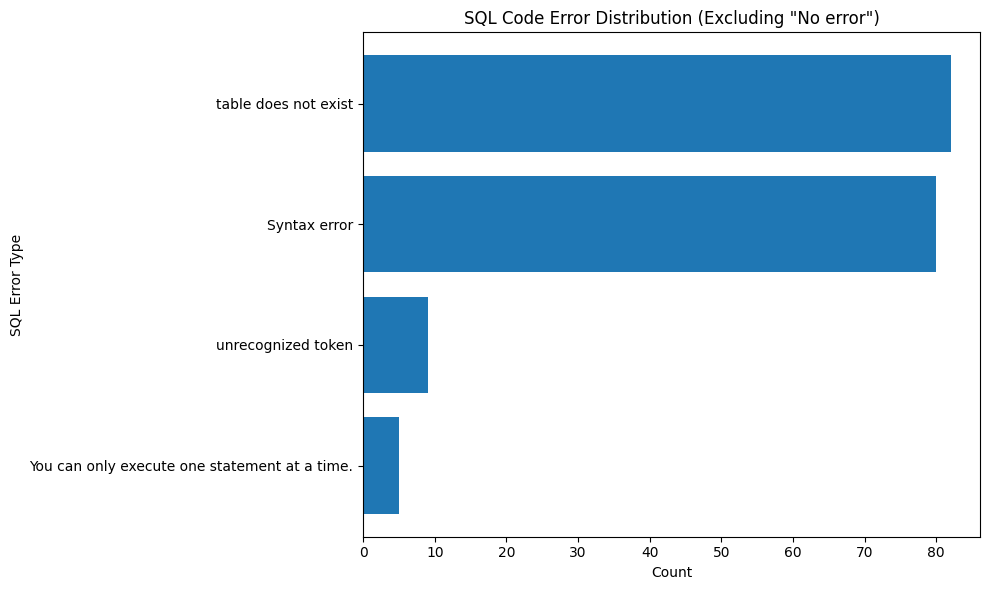

In [61]:
filtered_errors = {sql: error for sql, error in error_mapping.items() if error != 'No error'}

# Count the frequency of each error
error_counts = {}
for error in filtered_errors.values():
    error_counts[error] = error_counts.get(error, 0) + 1

# Plotting the errors (Horizontal bar plot)
plt.figure(figsize=(10, 6))

# Convert dict_keys to lists for the bar plot
plt.barh(list(error_counts.keys()), list(error_counts.values()))
plt.gca().invert_yaxis()  # Invert y-axis for better visual
plt.xlabel('Count')
plt.ylabel('SQL Error Type')
plt.title('SQL Code Error Distribution (Excluding "No error")')
plt.tight_layout()
plt.show()

Average turns to reach a conclusion:  SourceType
code file       11.588289
hacker news      5.017167
pull request     4.930000
issue            4.720461
discussion       4.372093
commit           2.976253
Name: NumberOfPrompts, dtype: float64


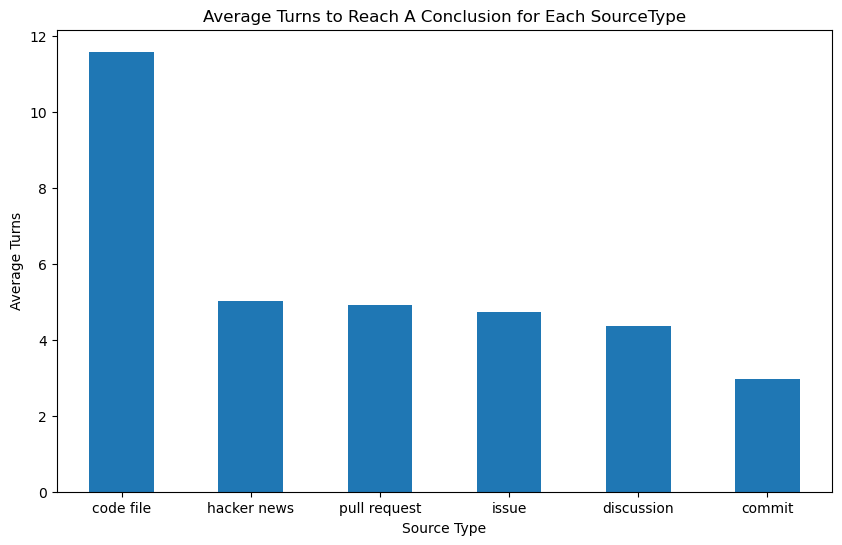

In [18]:
# Question 5: Conversation Structure

data_unique = data.drop_duplicates(subset = ['SourceType', 'SourceURL', 'NumberOfPrompts'])
average_turns = data_unique.groupby('SourceType')['NumberOfPrompts'].mean().sort_values(ascending = False)

print("Average turns to reach a conclusion: ", average_turns)

# bar plot
average_turns.plot(kind='bar', figsize=(10, 6))
plt.title('Average Turns to Reach A Conclusion for Each SourceType')
plt.xlabel('Source Type')
plt.ylabel('Average Turns')
_ = plt.xticks(rotation=0)

Mean Absolute Error (MAE): 3062.24
Root Mean Square Error (RMSE): 7106.31
R² Score: -0.23


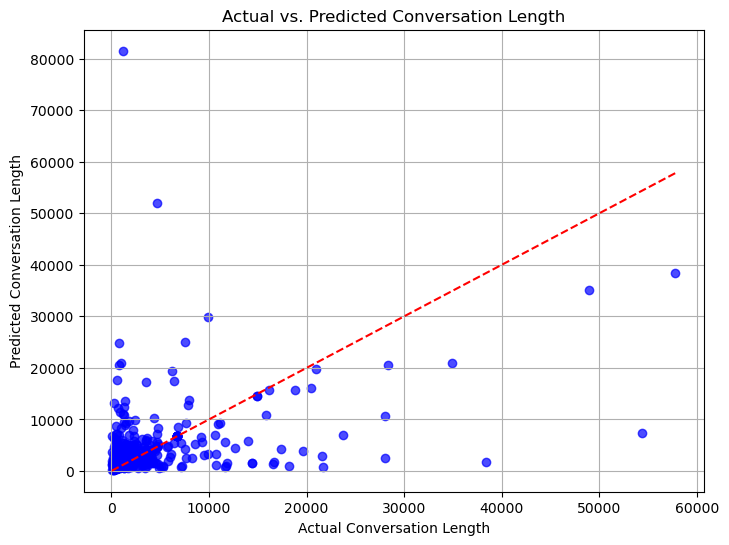

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

data_unique['conversation_length'] = data_unique['TokensOfPrompts'] + data_unique['TokensOfAnswers']
data_unique['ini_prompt'] = data_unique['Prompt'].apply(len)
data_unique['ini_answer'] = data_unique['Answer'].apply(len)

# Features and target variable
X = data_unique[['ini_prompt', 'ini_answer']]
y = data_unique['conversation_length']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Actual Conversation Length')
plt.ylabel('Predicted Conversation Length')
plt.title('Actual vs. Predicted Conversation Length')
plt.grid(True)
plt.show()